In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
from collections import defaultdict

In [2]:
def display_densiy(file, title):
    df = pickle.load(file)
    # REmove NaN values
    df = df.dropna()
    image_names = np.unique(df['image'] )

    # compute the average cell density
    densities=defaultdict(list)

    for image in image_names:
        image_data = df[df['image']==image].to_numpy()[:,[1,2]]
        for depth, value  in zip(image_data[:,0],image_data[:,1]):
            densities[depth].append(value)


    average={}
    median={}
    for key, value in densities.items():
        average[key] = np.average(value)
        median[key] = np.median(value)

    plt.figure(figsize=(3,3))
    for image in image_names:
        image_data = df[df['image']==image].to_numpy()[:,[1,2]]
        plt.plot(image_data[:,1], image_data[:,0])
    plt.plot(list(average.values()), list(average.keys()), linewidth=5, c='y', label='average values')
    plt.plot(list(median.values()),list(median.keys()), linewidth=5, c='black', label='median values')
    plt.title(f'{title} Cell density as a function of SSCX region percentage of depth.')
    plt.gca().set_ylabel("SSCX region percentage of depth")
    plt.gca().set_xlabel("Cell density cells/mm3")
    plt.gca().invert_yaxis()
    plt.legend()


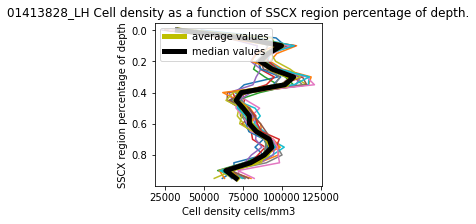

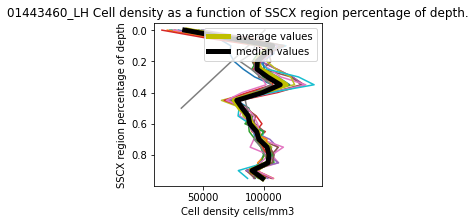

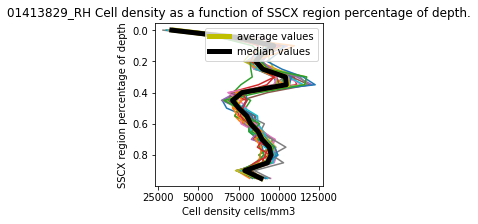

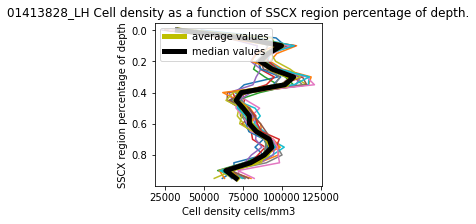

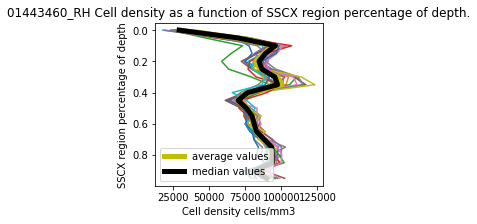

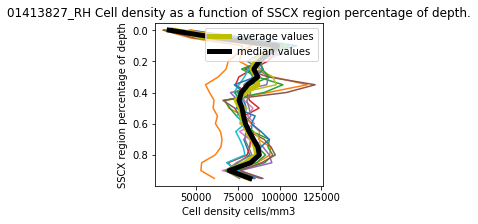

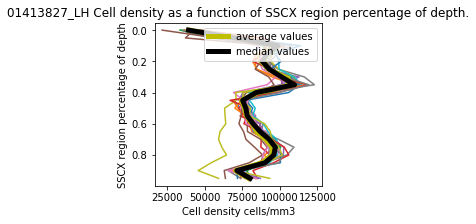

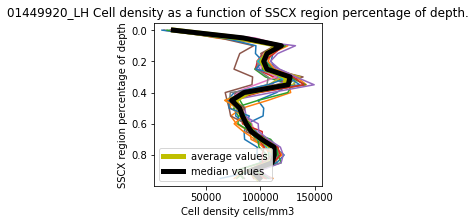

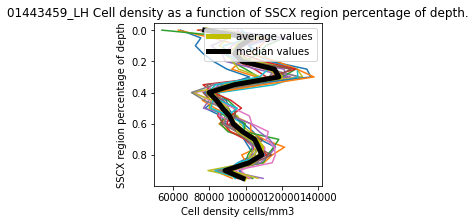

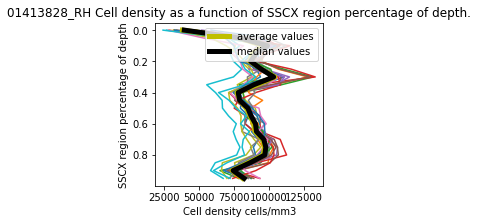

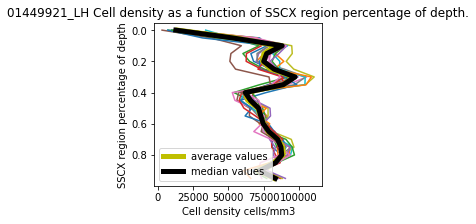

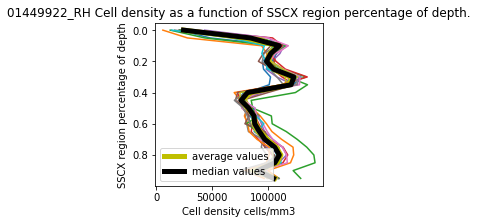

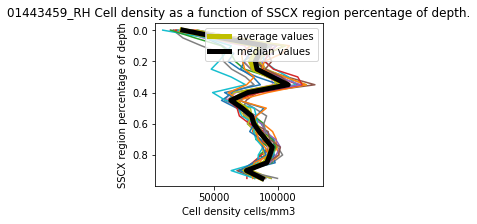

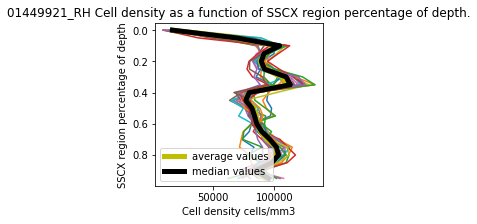

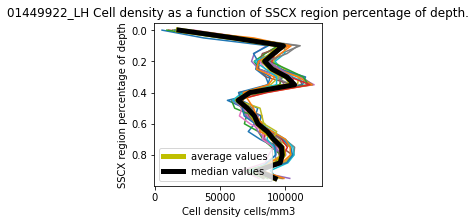

In [5]:
#file_list = [('../../../Production/Results/01413827_LH/1690967717.pkl', '01413827_LH')]

file_list =[('../../../Production/Results/01413828_LH/1690967717.pkl', '01413828_LH')
             ,('../../../Production/Results/01443460_LH/1690967717.pkl', '01443460_LH')
             ,('../../../Production/Results/01413829_RH/1690967717.pkl', '01413829_RH')
             ,('../../../Production/Results/01413828_LH/1690967717.pkl', '01413828_LH')
             ,('../../../Production/Results/01443460_RH/1690967717.pkl', '01443460_RH')
             ,('../../../Production/Results/01413827_RH/1690967717.pkl', '01413827_RH')
             ,('../../../Production/Results/01413827_LH/1690967717.pkl', '01413827_LH')
             ,('../../../Production/Results/01449920_LH/1690967717.pkl', '01449920_LH')
             ,('../../../Production/Results/01443459_LH/1690967717.pkl', '01443459_LH')
             ,('../../../Production/Results/01413828_RH/1690967717.pkl', '01413828_RH')
             ,('../../../Production/Results/01449921_LH/1690967717.pkl', '01449921_LH')
             ,('../../../Production/Results/01449922_RH/1690967717.pkl', '01449922_RH')
             ,('../../../Production/Results/01443459_RH/1690967717.pkl', '01443459_RH')
             ,('../../../Production/Results/01449921_RH/1690967717.pkl', '01449921_RH')
             ,('../../../Production/Results/01449922_LH/1690967717.pkl', '01449922_LH')]

for filename, title in file_list:
    file = open(filename, 'rb') 
    display_densiy(file, title)

In [4]:
file = open('../../../Production/Results/01413827_LH/1690967717.pkl', 'rb') 
df = pickle.load(file)
# REmove NaN values
df = df.dropna()
df.head

<bound method NDFrame.head of Empty DataFrame
Columns: [image, depth_percentage, densities]
Index: []>